In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import shutil
import sys
import time
import pprint
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.1.0
sys.version_info(major=3, minor=6, micro=5, releaselevel='final', serial=0)
matplotlib 2.2.2
numpy 1.18.1
pandas 0.25.3
sklearn 0.19.1
tensorflow 2.1.0
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf


In [2]:
housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

California housing dataset.

The original database is available from StatLib

    http://lib.stat.cmu.edu/datasets/

The data contains 20,640 observations on 9 variables.

This dataset contains the average house value as target variable
and the following input variables (features): average income,
housing average age, average rooms, average bedrooms, population,
average occupation, latitude, and longitude in that order.

References
----------

Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,
Statistics and Probability Letters, 33 (1997) 291-297.


(20640, 8)
(20640,)


In [3]:
pprint.pprint(housing.data[0:5])
pprint.pprint(housing.target[0:5])

array([[ 8.32520000e+00,  4.10000000e+01,  6.98412698e+00,
         1.02380952e+00,  3.22000000e+02,  2.55555556e+00,
         3.78800000e+01, -1.22230000e+02],
       [ 8.30140000e+00,  2.10000000e+01,  6.23813708e+00,
         9.71880492e-01,  2.40100000e+03,  2.10984183e+00,
         3.78600000e+01, -1.22220000e+02],
       [ 7.25740000e+00,  5.20000000e+01,  8.28813559e+00,
         1.07344633e+00,  4.96000000e+02,  2.80225989e+00,
         3.78500000e+01, -1.22240000e+02],
       [ 5.64310000e+00,  5.20000000e+01,  5.81735160e+00,
         1.07305936e+00,  5.58000000e+02,  2.54794521e+00,
         3.78500000e+01, -1.22250000e+02],
       [ 3.84620000e+00,  5.20000000e+01,  6.28185328e+00,
         1.08108108e+00,  5.65000000e+02,  2.18146718e+00,
         3.78500000e+01, -1.22250000e+02]])
array([4.526, 3.585, 3.521, 3.413, 3.422])


In [4]:
x_train_all, x_test, y_train_all, y_test = train_test_split(housing.data, housing.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, random_state=11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [5]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [6]:
#函数式API 功能API
input = keras.layers.Input(shape=x_train.shape[1:])
hidden1 = keras.layers.Dense(30,activation='relu')(input)
hidden11=keras.layers.BatchNormalization()(hidden1)   #批归一化

hidden2 = keras.layers.Dense(30,activation='relu')(hidden11)
hidden21=keras.layers.BatchNormalization()(hidden2)   #批归一化

hidden3= keras.layers.Dense(30,activation='relu')(hidden21)
hidden31=keras.layers.BatchNormalization()(hidden3)   #批归一化


concat = keras.layers.concatenate([input, hidden31])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input],
                          outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 30)           120         dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           930         batch_normalization[0][0]        
______________________________________________________________________________________________

In [7]:
model.compile(loss="mean_squared_error",optimizer="adam",metrics=["accuracy"])

#重新建立文件夹
logdir = './wide_deep'
if os.path.exists(logdir):
    shutil.rmtree(logdir)
os.mkdir(logdir)    
output_model_file = os.path.join(logdir,
                                "house_price_model.h5")

#Tensorboard, earlystopping, ModelCheckpoint
callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                   save_best_only=True),
    keras.callbacks.EarlyStopping(patience=10, min_delta=1e-3), #连续5次损失函数和上一次差距小于1e-3即可停止训练    
]
his = model.fit(x_train_scaled,y_train,epochs=20, 
         validation_data=(x_valid_scaled,y_valid),
                 callbacks = callbacks)  #epochs 训练次数
#终端命令 tensorboard --logdir=callbacks 

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 2s 130us/sample - loss: 2.0229 - accuracy: 0.0019 - val_loss: 0.6299 - val_accuracy: 0.0023
Epoch 2/20
11610/11610 [==============================] - 1s 60us/sample - loss: 0.5866 - accuracy: 0.0031 - val_loss: 0.5207 - val_accuracy: 0.0021
Epoch 3/20
11610/11610 [==============================] - 1s 60us/sample - loss: 0.5258 - accuracy: 0.0030 - val_loss: 0.4924 - val_accuracy: 0.0023
Epoch 4/20
11610/11610 [==============================] - 1s 57us/sample - loss: 0.4669 - accuracy: 0.0031 - val_loss: 0.5196 - val_accuracy: 0.0023
Epoch 5/20
11610/11610 [==============================] - 1s 60us/sample - loss: 0.4159 - accuracy: 0.0031 - val_loss: 0.4813 - val_accuracy: 0.0023
Epoch 6/20
11610/11610 [==============================] - 1s 57us/sample - loss: 0.4036 - accuracy: 0.0031 - val_loss: 0.4856 - val_accuracy: 0.0023
Epoch 7/20
11610/11610 [==============================] 

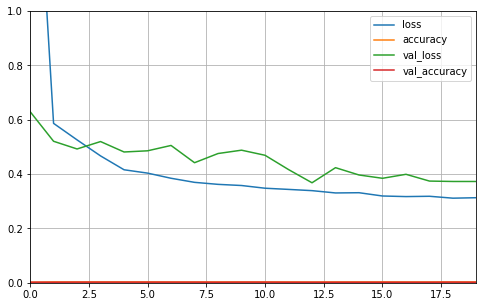

In [10]:
 def plot_learning_curves(his):
        pd.DataFrame(his.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()
        
plot_learning_curves(his)

In [9]:
model.evaluate(x_test_scaled, y_test)

5160/5160 [==============================] - 0s 21us/sample - loss: 0.5895 - accuracy: 0.0033


[0.5894544101500696, 0.0032945736]